# Example: Multiple Asset Geometric Brownian Motion (MGBM)
In this example, we simulate the price paths of multiple assets using the multi-asset Geometric Brownian Motion (GBM) model.

> __Learning Objectives:__
> 
> By the end of this example, you will be able to:
> 
> * **Implement multi-asset geometric Brownian motion models for portfolio simulation.** We extend single-asset GBM to multiple correlated assets using covariance matrices and Cholesky factorization, enabling simulation of portfolio dynamics where asset prices move together according to their historical correlations.
> * **Apply Cholesky factorization to incorporate asset correlations in stochastic simulations.** We learn how to decompose covariance matrices using Cholesky factorization to generate correlated random variables, ensuring that simulated asset price movements reflect realistic interdependencies observed in financial markets.
> * **Simulate portfolio performance using Monte Carlo methods and visualize uncertainty.** We generate 1000 possible portfolio trajectories to compute expected wealth paths and statistical confidence bands (68%, 95%, 99%), then create visualizations that display the range of potential portfolio outcomes alongside benchmark comparisons.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `09-26-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [2]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 482 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days to ensure we have consistent, complete time series for reliable analysis.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

182

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Next, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

Now, let's load the GBM parameters that we computed in the previous example:

In [6]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

In [7]:
parameters_df

Row,ticker,drift,t,lower_bound_drift,upper_bound_drift,volatility
,String7,Float64,Float64,Float64,Float64,Float64
1,A,0.147468,1.96,0.145161,0.149774,0.231426
2,AAL,-0.141294,1.96,-0.1436,-0.138988,0.454992
3,AAP,-0.0481021,1.96,-0.0504085,-0.0457958,0.342562
4,AAPL,0.24271,1.96,0.240403,0.245016,0.234474
5,ABBV,0.116,1.96,0.113693,0.118306,0.242938
6,ABT,0.123083,1.96,0.120777,0.125389,0.199723
7,ACN,0.151012,1.96,0.148706,0.153319,0.214367
8,ADBE,0.224401,1.96,0.222094,0.226707,0.276273
9,ADI,0.146449,1.96,0.144142,0.148755,0.259329


Next, let's load the covariance matrix that we computed in the previous example:

In [8]:
covariance_dictionary = let

    # initialize -
    path_to_covariance = joinpath(_PATH_TO_DATA,"Covariance-Return-Training-Fall-2025.jld2");
    covariance = JLD2.load(path_to_covariance);
    covariance;
end;

### Constants and Parameters
Let's define some constants and parameters that we will use in our simulations. See the comments next to each constant for additional information, including values, units, etc.

In [9]:
Δt = (1.0/252.0); # time step (1 trading day, in years)
TSIM = 182; # number of trading days to simulate (1 quarter, in trading days)
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;
startdate = Date(2025,1,1); # start date of simulation

___

## Compute the dynamics of random portfolios
Let's simulate the price paths of multiple assets using the multi-asset Geometric Brownian Motion (GBM) model. First, we select some `tickers`$\in\mathcal{P}$ and compute the drift and covariance for the selected tickers. 

In [10]:
my_list_of_tickers = ["AMD", "NVDA", "MU", "INTC", "AAPL", "PG", "DPZ"]; # select some tickers

Now that we have selected the firm tickers in our risky portfolio, we'll compute the firm-specific drift vector and covariance matrix for our portfolio. 

In [11]:
Σ = covariance_dictionary["covariance_matrix"] # full covariance matrix

424×424 Matrix{Float64}:
 0.0535771   0.032397    0.0212982  …  0.0355662   0.0280938   0.0266666
 0.032397    0.207093    0.0431437     0.051429    0.0689041   0.0280481
 0.0212982   0.0431437   0.117391      0.0308539   0.037867    0.019717
 0.0229702   0.0312627   0.0163174     0.032633    0.0201827   0.022609
 0.0179206   0.0176175   0.0158407     0.0157326   0.0168026   0.0185472
 0.0244078   0.0195811   0.0145372  …  0.023159    0.0167416   0.0221966
 0.025643    0.0334402   0.0218931     0.0313218   0.0280694   0.023824
 0.0294242   0.02952     0.0185233     0.0369478   0.0198333   0.0262802
 0.0297618   0.0458278   0.0231343     0.0433011   0.0335821   0.0233085
 0.0169025   0.0325409   0.0206063     0.0219846   0.0327002   0.0131991
 ⋮                                  ⋱                          
 0.0339199   0.0921199   0.035255   …  0.0503196   0.0581754   0.0308858
 0.00888225  0.00814595  0.0118987     0.00616705  0.00592554  0.0112662
 0.0161836   0.0376862   0.0190661    

In [12]:
μ̂, Σ̂ᵣ = let

    # initialize -
    M = length(my_list_of_tickers); # number of assets in portfolio
    μ = Array{Float64,1}(); # drift vector
    Σᵣ = Array{Float64,2}(undef, M, M); # covariance matrix for *our* portfolio
    tickers_in_parameters = parameters_df[:, :ticker] |> collect; # list of tickers in parameters_df
    covariance_ticker_list = covariance_dictionary["list_of_tickers"] |> collect; # list of tickers in covariance dictionary
    Σ = covariance_dictionary["covariance_matrix"]; # full covariance matrix

    # compute drift vector -
    for ticker ∈ my_list_of_tickers
        i = findfirst(x-> x == ticker, tickers_in_parameters); # find index of ticker in the parameters_df
        push!(μ, parameters_df[i, :drift]); # append drift value to μ
    end

    # compute covariance matrix -
    for i ∈ 1:M
        for j ∈ 1:M
            row_index = findfirst(x-> x == my_list_of_tickers[i], covariance_ticker_list); # find row index in full covariance matrix
            col_index = findfirst(x-> x == my_list_of_tickers[j], covariance_ticker_list); # find column index in full covariance matrix
            Σᵣ[i,j] = Σ[row_index, col_index]; # assign value to Σᵣ
        end
    end

    (μ, Σᵣ); # return
end;

### Compute the $\mathbf{A}$ matrix using Cholesky factorization 
Finally, we factor the covariance matrix $\Sigma = \mathbf{A}\mathbf{A}^{\top}$ using a [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) to get the $a_{ij}$ coefficients which appear in the noise term of the multi-asset geometric Brownian motion expression. We'll use the [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) routine implemented in the [LinearAlgebra.jl package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/), which is part of the [Julia standard library](https://docs.julialang.org/en/v1/).

> __What is going on?__ We call the [cholesky function](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.cholesky) with the covariance matrix `Σ̂ᵣ` as an argument. This returns the matrix factorization in the [Cholesky type](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.Cholesky), which has the `L` and `U` fields, holding the `lower` and `upper` triangular factorizations, respectively. We convert the `lower` triangular factor into a [Matrix type](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix) so that we can do computations with it later. We store this matrix in the variable $\mathbf{A}$, where the coefficients $a_{ij}\in\mathbf{A}$.

So what do we get?

In [13]:
A,Ā = let 
    factors = cholesky(Σ̂ᵣ);
    A = factors.L |> x-> Matrix(x)
    Ā = diagm(0 => diag(A))
    (A, Ā)
end;

#### Check: Is the Cholesky factorization legit?
Before we use the [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) in our multi-asset simulation, let's check that we can recover the original firm-specific covariance matrix `Σ̂ᵣ`. We know that $\mathbf{A}\mathbf{A}^{\top} = \Sigma$, so let's compare `Σ̂ᵣ` and the matrix product $\mathbf{A}\mathbf{A}^{\top}$ using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) with `rtol = 1e-6` (or you can choose some other random small value).
> __Test__ If the `Σ̂ᵣ` and the matrix product $\mathbf{A}\mathbf{A}^{\top}$ are `NOT` close, i.e., the difference between them is larger than the `rtol` value, the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) will evaluate to `false` and the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) will throw an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). Otherwise, nothing happens (which is good).

Did we pass the test? If you did not get an error, then yes!

In [14]:
@assert isapprox(Σ̂ᵣ, A*transpose(A), rtol = 1e-6)

### Set the initial conditions, the time range, and other parameters
Now, we set up several constants and other data for the multi-asset simulation. 

In [15]:
Sₒ = let

    # initialize -
    Sₒ = Array{Float64,1}(); # initial stock prices vector

    # populate -
    for ticker ∈ my_list_of_tickers
        data = dataset[ticker]; # get the data for the ticker
        price = data[1, :close]; # get the first closing price
        push!(Sₒ, price); # append to Sₒ
    end
    Sₒ; # return
end

7-element Vector{Float64}:
 125.37
 144.47
  89.87
  20.56
 243.36
 165.13
 438.08

### Run the multi-asset simulation to compute the share price trajectories
Following from the single asset case, we construct an instance of [the `MyMultipleAssetGeometricBrownianMotionEquityModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyMultipleAssetGeometricBrownianMotionEquityModel), where we pass the drift vector $\mu$ and the factored covariance matrix $\mathbf{A}$ into [a `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMultipleAssetGeometricBrownianMotionEquityModel},%20NamedTuple}):

In [16]:
model = build(MyMultipleAssetGeometricBrownianMotionEquityModel, (
        μ = μ̂, A = A
));

Then we pass the start time `T₁,` the stop time `T₂`  for the simulation, the initial conditions `Sₒ,` the time step `Δt,` and other simulation parameters along with the `model` instance into the `sample(...)` function. This function computes `number_of_paths` sample paths and returns the simulated data in the `simulation_dictionary` variable.

The `simulation_dictionary` data structure holds a simulation array for each sample path, where the simulation array has time in the first column and the simulated price for each asset in columns $2\dots\dim\mathcal{L}$. Each row is a time value; there will be `T+1` rows for each simulation array.

In [ ]:
simulation_dictionary = let
    
    # initialize -
    start_index = 1;
    stop_index = TSIM + start_index - 1;
    number_of_trials = 1000; # number of sample paths to compute

    # specify the time range -
    T₁ = start_index*Δt # start time (in years)
    T₂ = stop_index*Δt # end time (in years)

    # run the simulation -
    simulation_dictionary = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
        number_of_paths = number_of_trials);

    simulation_dictionary; # return 
end;

For example, we can access the data `samplepath = 1` by issuing the command:

In [ ]:
simulation_dictionary[1] # this will give me the simulation results for the first trial (a sample future for all M firms)

182×8 Matrix{Float64}:
 0.00396825  125.37   144.47    89.87    20.56    243.36   165.13   438.08
 0.00793651  126.905  147.497   97.7585  20.0506  236.454  164.816  449.256
 0.0119048   131.374  148.545   99.2368  20.6204  235.618  163.862  453.837
 0.015873    133.383  150.819  100.056   20.522   235.688  168.899  452.675
 0.0198413   136.866  158.366   97.8618  20.7033  231.823  166.587  449.036
 0.0238095   135.095  157.226   98.1091  21.2916  232.599  166.665  453.216
 0.0277778   132.274  152.842   98.631   21.7032  234.611  164.286  447.451
 0.031746    145.257  155.248   94.7996  21.5351  237.178  164.868  441.041
 0.0357143   145.674  156.004   97.2086  21.2781  227.628  163.15   435.498
 0.0396825   152.343  153.667  100.621   20.6197  227.925  160.805  451.287
 ⋮                                                  ⋮               
 0.690476    148.212  265.866  107.513   17.0717  284.852  207.805  478.805
 0.694444    147.527  271.697  106.733   16.682   281.731  205.286  486.7

### Generate a random allocation $\omega$ for portfolio $\mathcal{P}$
First, let's specify how much we wish to invest in risky assets, and store this value in the `total_budget` variable:

In [19]:
total_budget = 1000.0;

Next, let's simulate the allocation of the `total_budget` to each `ticker`$\in\mathcal{P}$. Let the fraction of the investment budget allocated to firm $i$ be denoted as $w_{i}\in \mathbf{w}$, where $w_{i}>0$ and $\sum_{i\in\mathcal{P}}w_{i} = 1$ (full allocation, all risky assets).

> __There is more to this story!__
> 
> Today, we'll discuss [Modern Portfolio Theory (MPT)](https://en.wikipedia.org/wiki/Modern_portfolio_theory), which is a technique to __optimally compute__ the fraction of the investment budget allocated to each asset in a portfolio. However, for now, let's generate a random allocation vector $w$ using the [Dirichlet distribution](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.Dirichlet) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl).


If $x_{i}\in{X}$ are random draws from a [Dirichlet distribution](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.Dirichlet), each $x_{i}>0$ and $\sum_{i}x_{i} = 1$.

In [20]:
w = let
    
    # initialize -
    number_of_states = length(my_list_of_tickers); # number of assets in portfolio
    
    # TODO: uncomment the case that you want to use
    # Case 1: random allocation
    w = (1/number_of_states)*ones(number_of_states) |> x -> Dirichlet(x) |> d->rand(d); # random allocation

    # Case 2: equal allocation
    # w = (1/number_of_states)*ones(number_of_states); # equal allocation

    # Case 3: custom allocation: NVDA only
    # nvda_index = findfirst(x-> x == "NVDA", my_list_of_tickers);
    # w = zeros(number_of_states);
    # w[nvda_index] = 1.0; # 100% allocation to NVDA

    # Check: non-negativity constraint
    for wᵢ ∈ w
        @assert wᵢ ≥ 0.0
    end

    # Check: summation constraint
    @assert sum(w) ≈ 1.0 rtol = 1e-4 

    # return
    w;
end;

Now that we have the `total_budget`, an allocation vector $\mathbf{w}$, and the share price array `Sₒ`, we compute the number of shares of each asset that corresponds to the random allocation and store these values in the `Nₒ::Array{Float64,1}` variable. 

> __What's in the initial share vector?__ Each entry in the `Nₒ` array is the initial number of shares we purchase at the start of the investment. For this case study, we allow for fractional shares. This may not be possible in real life, but it simplifies the calculations.

So how many shares of each asset did we buy at the start of the investment?

In [21]:
Nₒ = let
    
    # initialize -
    Nₒ = Array{Float64,1}()

    # compute number of shares for each asset
    for i ∈ eachindex(w)

        wᵢ = w[i]
        nᵢ = (wᵢ*total_budget)/Sₒ[i];
        push!(Nₒ,nᵢ)
    end
    Nₒ;
end;

Let's make a table to summarize our initial investment [using the `pretty_table(...)` function exported by the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl).

In [22]:
let

    # initialize -
    df = DataFrame();

    for (i, ticker) ∈ enumerate(my_list_of_tickers)
        Sₒᵢ = Sₒ[i]
        wᵢ = w[i]
        nᵢ = Nₒ[i]
        total_investmentᵢ = wᵢ*total_budget
        temp_df = (Ticker = ticker, Initial_Price = Sₒᵢ, Allocation_w = wᵢ, Number_of_Shares = nᵢ, Total_Investment = total_investmentᵢ);
        df = push!(df, temp_df);
    end

    # build a table -
    pretty_table(df, backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact))

end

 -------- --------------- -------------- ------------------ ------------------
  Ticker   Initial_Price   Allocation_w   Number_of_Shares   Total_Investment 
  String         Float64        Float64            Float64            Float64 
 -------- --------------- -------------- ------------------ ------------------
     AMD          125.37       0.840282            6.70242            840.282
    NVDA          144.47    0.000540143         0.00373879           0.540143
      MU           89.87       0.034486           0.383732             34.486
    INTC           20.56     0.00278094            0.13526            2.78094
    AAPL          243.36       0.118948           0.488774            118.948
      PG          165.13     0.00296145          0.0179341            2.96145
     DPZ          438.08     1.17298e-6         2.67755e-6         0.00117298
 -------- --------------- -------------- ------------------ ------------------


#### Compute the simulated wealth of portfolio $\mathcal{P}$ given our allocation
`Unhide` the code block below to see how we computed the __simulated wealth__ of the portfolio $\mathcal{P}$ for the allocation specified above. We store the simulation data in the `simulated_wealth_array::Array{Float64,2}` variable.

> __What's in the simulated wealth array?__ Each column in the `simulated_wealth_array` corresponds to a sample path from the multi-asset GBM simulation. Each row corresponds to a time value. The entries in the array are the total wealth of the portfolio $\mathcal{P}$ at each time for each sample path.

Let's compute the simulated wealth of our portfolio $\mathcal{P}$.

In [23]:
simulated_wealth_array = let

    # initialize -
    number_of_trials = length(simulation_dictionary) # number of trials
    number_of_days = simulation_dictionary[1] |> m -> size(m,1) # number of days in each trial
    M = length(my_list_of_tickers); # number of assets in portfolio
    simulated_wealth_array = Array{Float64,2}(undef, number_of_days, number_of_trials);
   
    # compute the wealth for each trial 
    for i ∈ 1:number_of_trials
        
        simulation_array = simulation_dictionary[i]
        
        portfolio_performance_array = Array{Float64,2}(undef, number_of_days, M+1)
        for j ∈ eachindex(my_list_of_tickers)
        
            ticker = my_list_of_tickers[j];
            price_data = simulation_array[:,j+1];
            nⱼ = Nₒ[j]
        
            for k ∈ 1:number_of_days
                portfolio_performance_array[k,j] = nⱼ*price_data[k];
            end
        end
    
        # total -
        for j ∈ 1:number_of_days
            portfolio_performance_array[j,end] = sum(portfolio_performance_array[j,1:end-1])
        end
        
        # wealth -
        for j ∈ 1:number_of_days
            simulated_wealth_array[j,i] = portfolio_performance_array[j,end];
        end
    end
    simulated_wealth_array;
end

182×1000 Matrix{Float64}:
 1000.0   1000.0    1000.0    1000.0    …  1000.0    1000.0    1000.0
 1009.88  1010.07   1011.96   1002.96       943.772  1000.13    989.281
 1040.05   979.149   981.782  1000.18       959.858  1016.35   1018.89
 1053.95   984.255   971.183   982.044     1004.79    995.701  1059.69
 1074.57   962.376   975.382   997.178      979.853  1005.65   1056.6
 1063.26  1010.48    982.701  1024.09   …   978.123   996.343  1056.86
 1045.53   993.368  1010.73   1015.41       958.634  1050.6    1074.29
 1132.33   987.876   999.154  1036.14       940.572  1074.69   1066.36
 1131.32   986.748   988.984  1062.73       982.641  1103.96   1063.96
 1177.33   966.684  1015.93   1001.4        977.058  1096.51   1084.51
    ⋮                                   ⋱                      
 1180.89  2519.81   1132.61   1728.34       766.136   945.117  1233.02
 1174.4   2315.11   1092.12   1682.77       754.752   933.293  1286.29
 1176.79  2289.52   1094.11   1698.03   …   748.867   911.0

#### Compute the __actual wealth__ of portfolio $\mathcal{P}$ given our allocation
`Unhide` the code block below to see how we computed the __actual wealth__ of the portfolio $\mathcal{P}$ for the allocation specified above. We store the simulation data in the `actual_portfolio_performance_array::Array{Float64,2}` variable.

> __What's in the actual wealth array?__ Each row in the `actual_portfolio_performance_array` corresponds to a time value. The entries in the array are the total wealth of the portfolio $\mathcal{P}$ at each time for the actual market data.

Let's compute the actual wealth of our portfolio $\mathcal{P}$.

In [24]:
actual_portfolio_performance_array = let


    # initialize -
    number_of_trials = length(simulation_dictionary) # number of trials
    number_of_days = simulation_dictionary[1] |> m -> size(m,1) # number of days in each trial
    M = length(my_list_of_tickers); # number of assets in portfolio
    actual_portfolio_performance_array = Array{Float64,2}(undef, number_of_days, M+1)
    
    # compute the wealth for each trial
    for i ∈ eachindex(my_list_of_tickers)
        
        ticker = my_list_of_tickers[i];
        price_df = dataset[ticker];
        ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
        nᵢ = Nₒ[i]
        
        for j ∈ 1:number_of_days
            actual_portfolio_performance_array[j,i] = nᵢ*ticker_data[j,:volume_weighted_average_price];
        end
    end
    
    # total -
    for i ∈ 1:number_of_days
        actual_portfolio_performance_array[i,end] = sum(actual_portfolio_performance_array[i,1:end-1])
    end
    actual_portfolio_performance_array;
end

182×8 Matrix{Float64}:
  830.733  0.536471  34.2437  2.76461  118.811  2.96552  0.00117117   990.056
  867.822  0.561683  38.0001  2.74197  119.834  2.89105  0.0011449   1031.85
  862.323  0.537737  39.7614  2.71467  118.746  2.89405  0.0011102   1026.98
  817.519  0.525876  38.3043  2.68896  118.43   2.90089  0.00110319   980.37
  776.832  0.508129  38.0071  2.59191  115.647  2.85442  0.00108242   936.442
  778.181  0.493401  36.2969  2.569    113.764  2.85078  0.00108944   934.156
  777.363  0.494586  37.0516  2.58635  114.311  2.86133  0.00111416   934.669
  799.381  0.503993  39.4499  2.64236  116.123  2.86526  0.00111246   960.966
  798.237  0.507285  39.6437  2.66168  112.661  2.87264  0.0011232    956.584
  813.353  0.513758  40.203   2.87755  112.641  2.88741  0.00114026   972.477
    ⋮                                           ⋮                    
 1072.26   0.660085  60.5468  3.36971  115.516  2.81547  0.00120707  1255.17
 1075.18   0.656255  60.7977  3.39971  116.74   2.830

### Compute the wealth of an index portfolio
An alternative to building a portfolio of risky assets is to invest in an index fund that tracks a market index, such as the S&P 500. Let's use the [SPY ETF](https://en.wikipedia.org/wiki/SPDR_S%26P_500) as a proxy for the S&P 500 index, and compute our wealth if we had invested our entire `total_budget` in the SPY ETF at the start of our investment period.

> __What's in the benchmark wealth array?__ The `benchmark_wealth_array` is a one-dimensional array where each entry corresponds to the total wealth of the benchmark portfolio (SPY ETF) at each time value during the investment period. Here we are assuming we invested our entire `total_budget` in the SPY ETF at the start of the investment period.

Let's compute the benchmark wealth array.

In [25]:
benchmark_wealth_array = let

    # initialize -
    spy_data = dataset["SPY"];
    spy_data = filter(:timestamp => x-> x >= startdate, spy_data)
    number_of_days = size(spy_data,1)
    benchmark_wealth_array = Array{Float64,2}(undef, number_of_days, 1)

    # compute the wealth -
    for i ∈ 1:number_of_days
        benchmark_wealth_array[i,1] = (total_budget/spy_data[1,:volume_weighted_average_price])*spy_data[i,:volume_weighted_average_price];
    end
    benchmark_wealth_array;
end;

### Visualize simulated, actual and benchmark wealth arrays
`Unhide` the code block below to see how we plotted the performance of the __simulated__ and __actual__ portfolio $\mathcal{P}$ with our allocation $\mathbf{w}$, along with the benchmark performance of the SPY ETF.

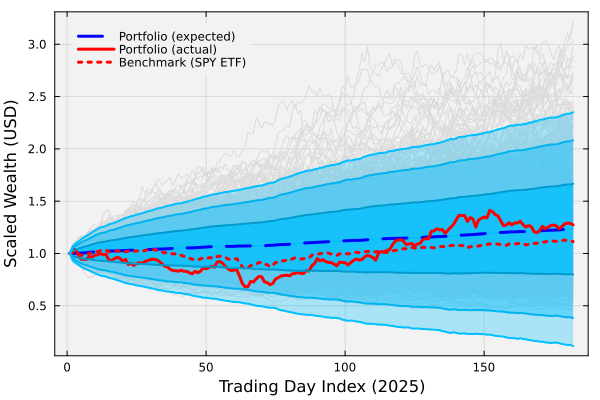

In [26]:
let

    # initialize -
    number_of_trials = length(simulation_dictionary) # number of trials
    p = plot(); # initialize an empty plot
    
    # plot the trajectories -
    for i ∈ 1:number_of_trials
        plot!((1/total_budget)*simulated_wealth_array[:,i], c=:gray86,lw=1, label="")
    end
    
    # compute the expected wealth array, and bounds 0
    expected_wealth_array = mean(simulated_wealth_array,dims=2)
    L68 = (1/total_budget)*(expected_wealth_array .- std(simulated_wealth_array,dims=2))
    U68 = (1/total_budget)*(expected_wealth_array .+ std(simulated_wealth_array,dims=2))
    plot!((1/total_budget)*expected_wealth_array,fillrange=L68, c=:deepskyblue1, alpha=0.75,label="")
    plot!((1/total_budget)*expected_wealth_array,fillrange=U68, c=:deepskyblue1, alpha=0.75, label="")
    
    L95 = (1/total_budget)*(expected_wealth_array .- 1.96*std(simulated_wealth_array,dims=2))
    U95 = (1/total_budget)*(expected_wealth_array .+ 1.96*std(simulated_wealth_array,dims=2))
    plot!((1/total_budget)*expected_wealth_array,fillrange=L95, c=:deepskyblue1, alpha=0.40,label="")
    plot!((1/total_budget)*expected_wealth_array,fillrange=U95, c=:deepskyblue1, alpha=0.40, label="")

    L99 = (1/total_budget)*(expected_wealth_array .- 2.576*std(simulated_wealth_array,dims=2))
    U99 = (1/total_budget)*(expected_wealth_array .+ 2.576*std(simulated_wealth_array,dims=2))
    plot!((1/total_budget)*expected_wealth_array,fillrange=L99, c=:deepskyblue1, alpha=0.30,label="")
    plot!((1/total_budget)*expected_wealth_array,fillrange=U99, c=:deepskyblue1, alpha=0.30, label="")
    
    plot!((1/expected_wealth_array[1]).*expected_wealth_array, ls=:dash, c=:blue, lw=3, label="Portfolio (expected)")
    plot!((1/actual_portfolio_performance_array[1,end]).*actual_portfolio_performance_array[:,end], lw=3, 
        c=:red, label="Portfolio (actual)")

    # plot the benchmark -
    plot!((1/total_budget)*benchmark_wealth_array, lw=3, ls=:dot, c=:red, label="Benchmark (SPY ETF)")

    plot!(L68, c=:deepskyblue3, lw=2, label="")
    plot!(U68, c=:deepskyblue3, lw=2, label="")
    plot!(L95, c=:deepskyblue2, lw=2, label="")
    plot!(U95, c=:deepskyblue2, lw=2, label="")
    plot!(L99, c=:deepskyblue1, lw=2, label="")
    plot!(U99, c=:deepskyblue1, lw=2, label="")
    
    
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    
    xlabel!("Trading Day Index (2025)", fontsize=18)
    ylabel!("Scaled Wealth (USD)", fontsize=18)
    current()
end

___

## Summary
In this example, we explored multi-asset geometric Brownian motion modeling to simulate realistic portfolio dynamics that account for correlations between different securities.

> __Key Takeaways:__
> * **Multi-asset GBM captures portfolio behavior through correlated price movements.** By incorporating covariance matrices estimated from historical data, the multi-asset model generates simulated price paths where assets move together in patterns consistent with their observed market relationships, providing more realistic portfolio simulations than independent single-asset models.
>
> * **Cholesky factorization enables efficient generation of correlated random variables.** The decomposition of covariance matrices into lower triangular factors allows us to transform independent random noise into correlated noise that drives correlated multi-asset price dynamics.
>
> * **Monte Carlo simulation quantifies portfolio outcome uncertainty through statistical measures.** Using 1000 simulation paths, we compute expected wealth trajectories and confidence intervals at multiple levels (68%, 95%, 99%), creating visual uncertainty bands that display the statistical distribution of potential portfolio performance relative to benchmark investments.

This framework provides the foundation for more sophisticated portfolio analysis, including optimal allocation strategies and risk management techniques that we'll explore in future lectures.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.